In [72]:
import pandas as pd
import numpy as np
from warnings import filterwarnings

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import skfuzzy as fuzz

import matplotlib.pyplot as plt
import seaborn as sns

filterwarnings("ignore")

datafile_path = "/tmp/entities-raw.csv"

df = pd.read_csv(datafile_path)

agg = (
    df.groupby(["sparkAppId", "sparkAppName"])
    .agg(
        {
            "inputRecords": "sum",
            "inputBytes": "sum",
            "stageId": "count",
            "numTasks": "sum",
            "dynamicAllocationMinExecutors": "min",
            "dynamicAllocationMaxExecutors": "min",
            "peakExecutionMemory": "max",
            "numExecutorsAssocStage": "max",
            "shuffleReadBytes": "sum",
            "shuffleWriteBytes": "sum",
            "totalTimeSec": "sum",
        }
    )
    .sort_values(["shuffleReadBytes"], ascending=False)
)
agg.to_csv("/tmp/agg.csv", index=True)
df.isnull().sum()

agg.rename(
    columns={
        "stageId": "numStages",
        "numExecutorsAssocStage": "numMaxUsedExecutors",
        "dynamicAllocationMinExecutors": "dynAllocMinExecutors",
        "dynamicAllocationMaxExecutors": "dynAllocMaxExecutors",
    },
    inplace=True,
)

# relevant_cols = [
#     "inputRecords",
#     "inputBytes",
#     "numTasks",
#     "numStages",
#     "dynAllocMinExecutors",
#     "dynAllocMaxExecutors",
#     "numMaxUsedExecutors",
#     "peakExecutionMemory",
#     "shuffleReadBytes",
#     "shuffleWriteBytes",
#     "totalTimeSec"
# ]

relevant_cols = ["inputRecords", "inputBytes", "peakExecutionMemory", "totalTimeSec"]

agg.reset_index(drop=True)

df_aux = agg[relevant_cols]
df_aux

,,inputRecords,inputBytes,peakExecutionMemory,totalTimeSec
sparkAppId,sparkAppName,,,,
application_1692342312988_100897,musta,103361805,4504874309,7931953152,98
application_1692342312988_100903,pyspark-shell,103361827,4505005381,7931953152,62
application_1692342312988_100887,pyspark-shell,7218025,2663412330,3407872000,95
application_1692342312988_100889,pyspark-shell,275555,12131028,3407872000,8
application_1692342312988_100894,pyspark-shell,137766,6014600,0,1
application_1692342312988_100880,PySparkShell,622430084,16813556738,548405248,137
application_1692342312988_100891,pyspark-shell,640937186,17915114206,306708480,157
application_1692342312988_100883,pyspark-shell,111445,4900488,0,5
application_1692342312988_100876,pyspark-shell,16,1208,0,1


In [66]:
# Set number of cluster (previously calculated with Elbow method)
NUM_CLUSTERS = 4

**GaussianMixture**

prediction
1    11
2     2
3     2
0     2
Name: count, dtype: int64

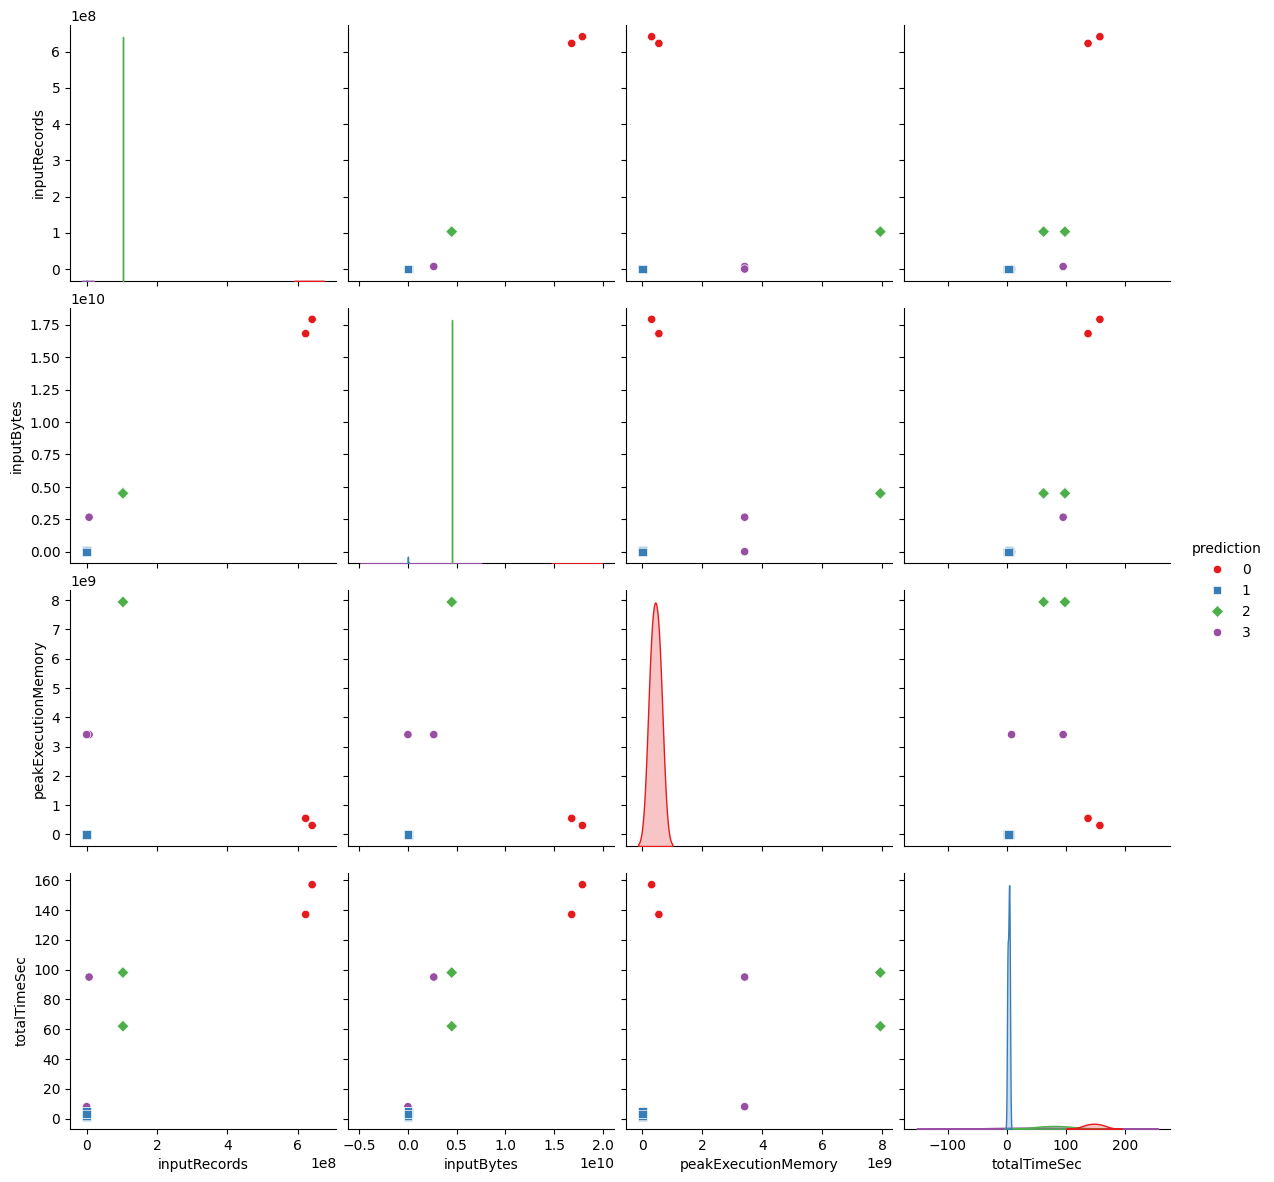

In [73]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Specify the number of clusters (k)
k = NUM_CLUSTERS

# Train a Gaussian Mixture Model
gmm = GaussianMixture(n_components=k, random_state=42, n_init=200, max_iter=1000, init_params="k-means++")
labels = gmm.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)

OUTPUT_FILE = "/tmp/clustering_gaussian_mixture.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

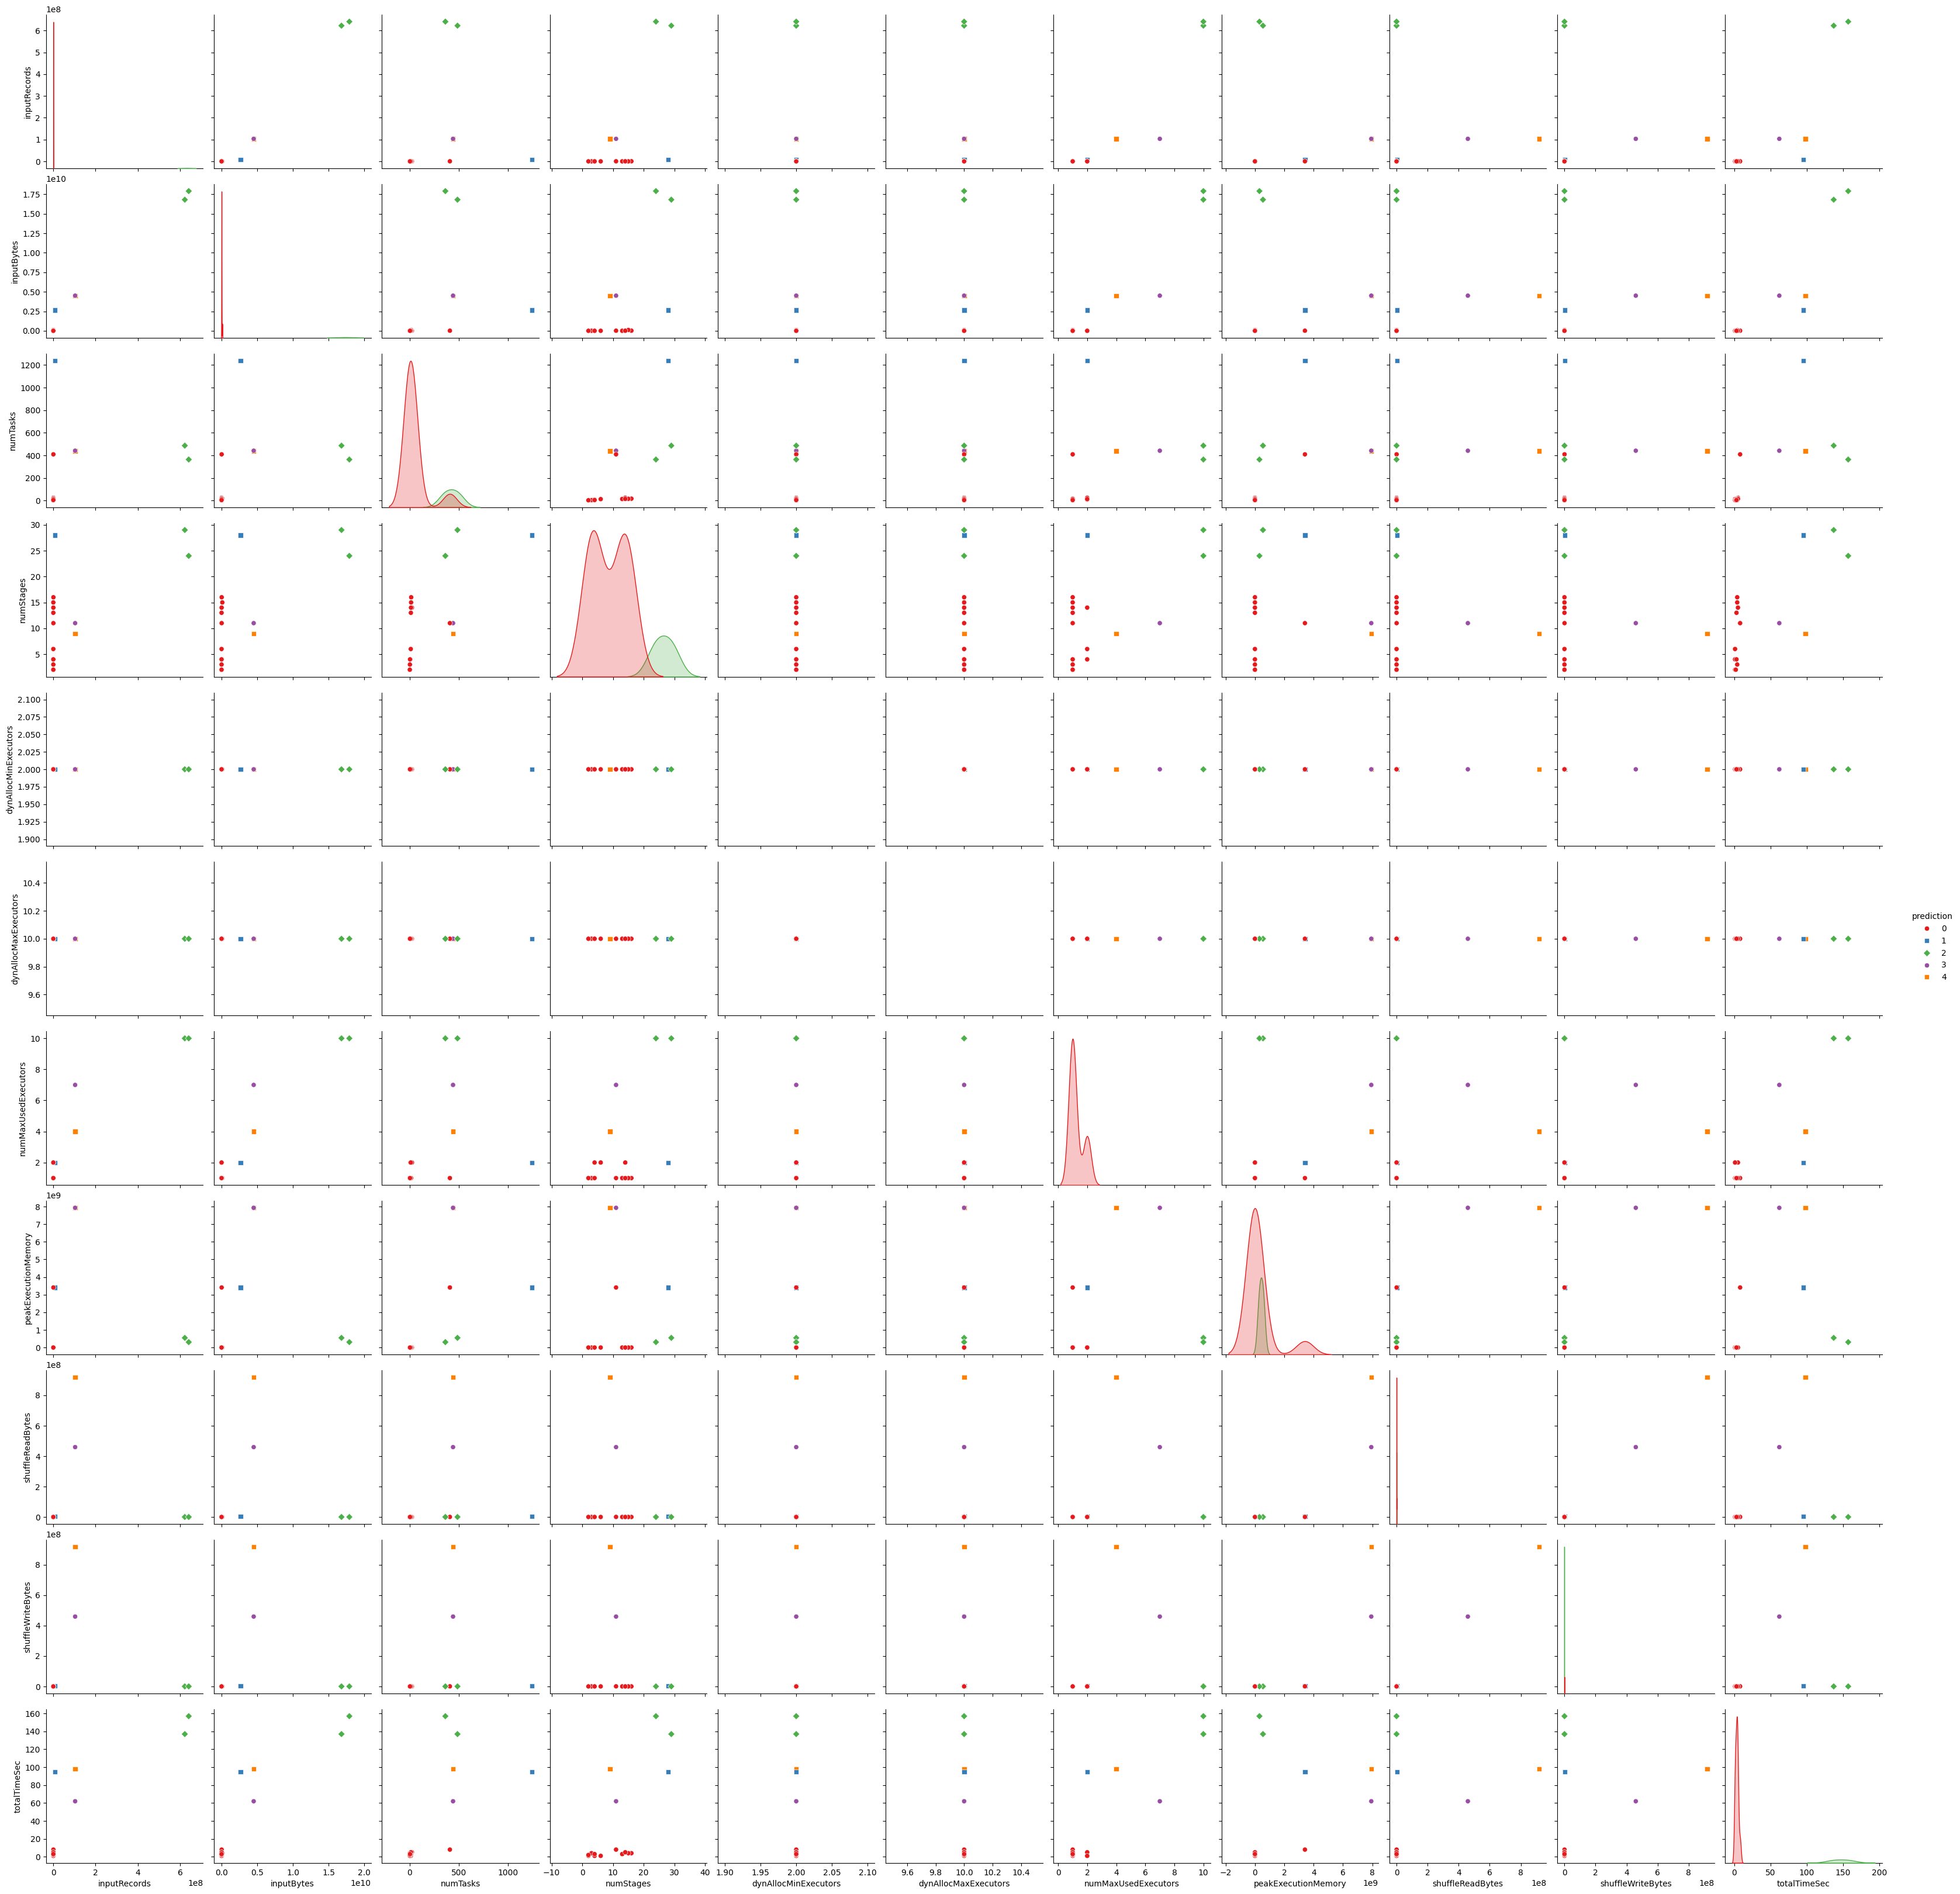

prediction
0    12
2     2
4     1
3     1
1     1
Name: count, dtype: int64

In [60]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Specify the number of clusters (k)
k = NUM_CLUSTERS

# Train a BIRCH model
birch = Birch(n_clusters=k)
birch.fit(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = birch.predict(df_scaled)

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_birch.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

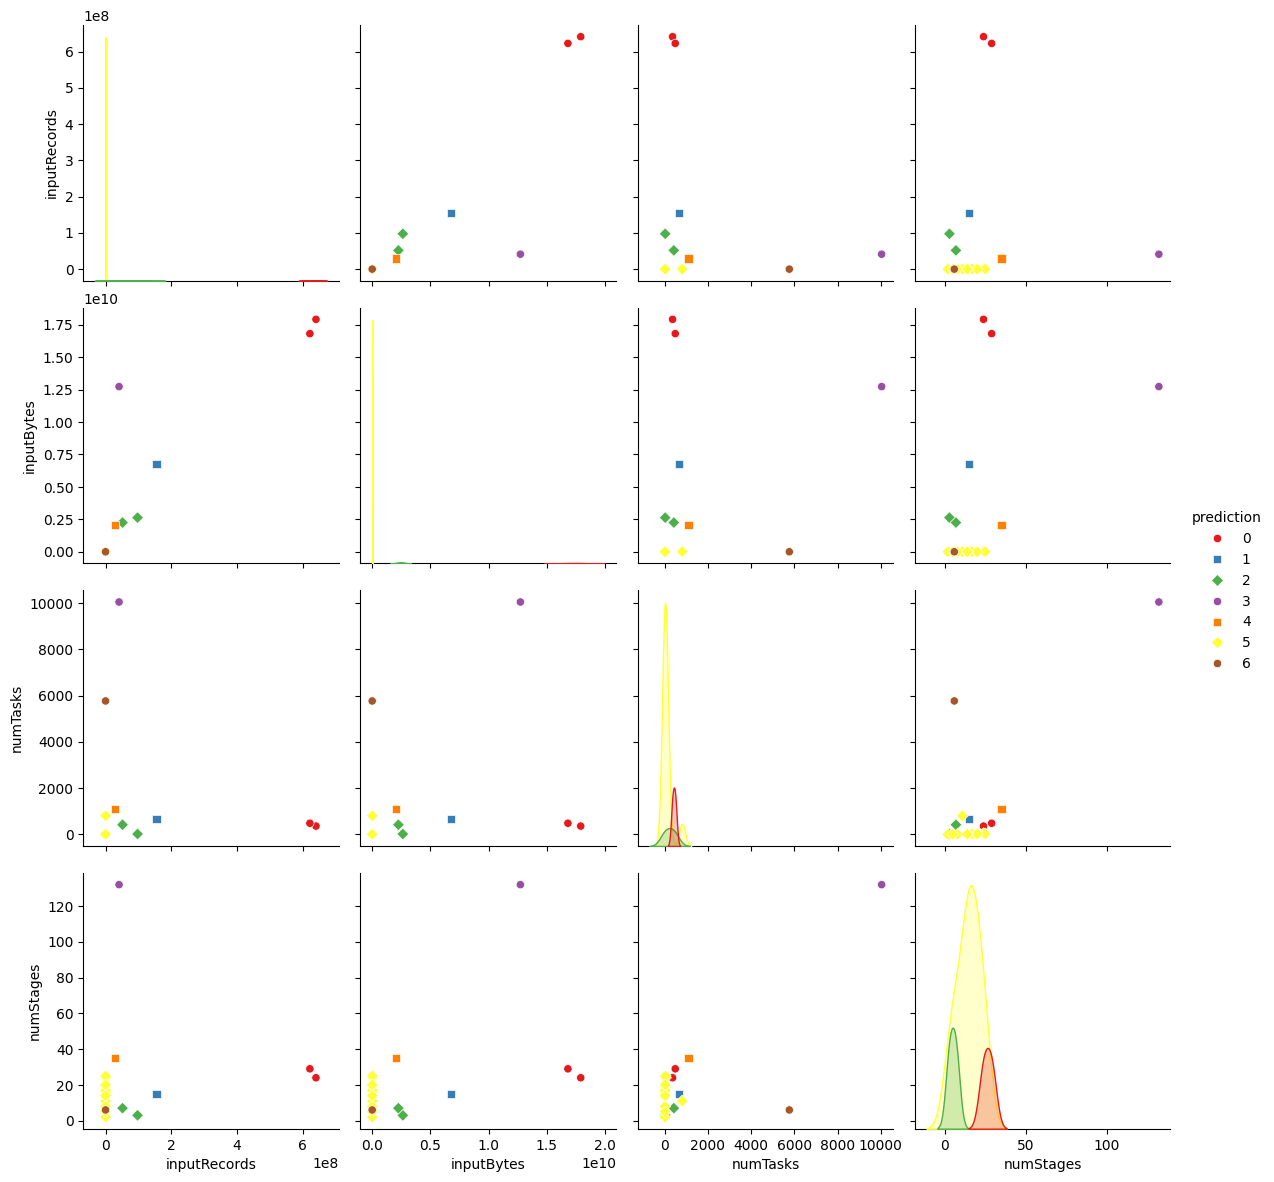

prediction
5    12
0     2
2     2
1     1
3     1
4     1
6     1
Name: count, dtype: int64

In [22]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Train an Affinity Propagation model
affinity_propagation = AffinityPropagation()
labels = affinity_propagation.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_affinity_propagation.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

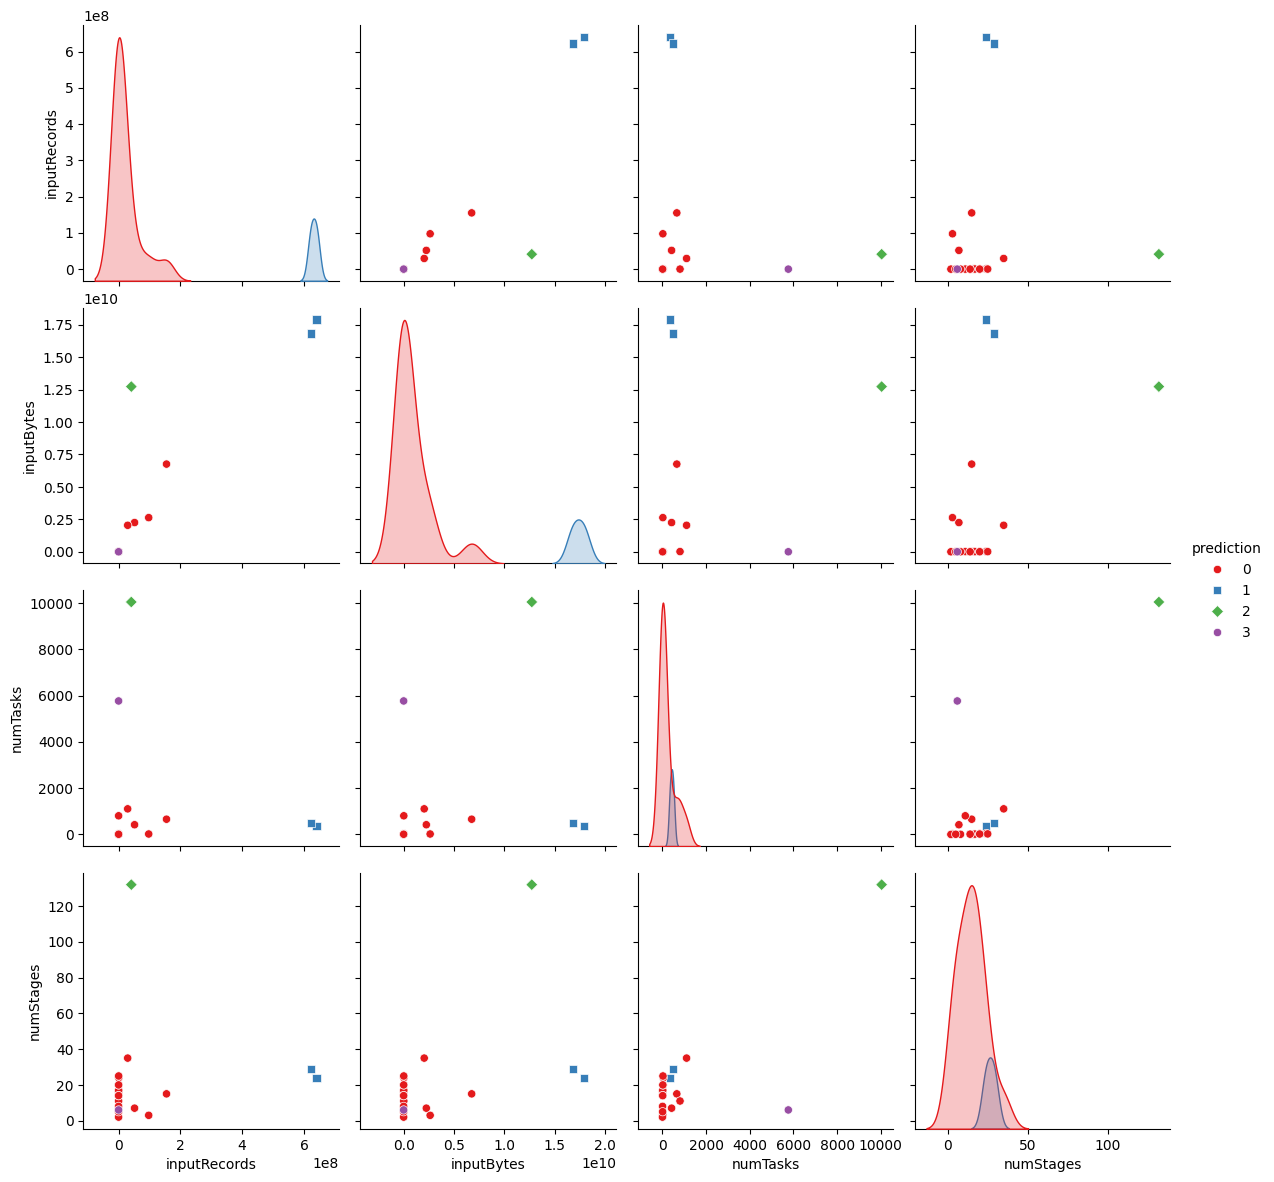

prediction
0    16
1     2
2     1
3     1
Name: count, dtype: int64

In [23]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Train a Mean Shift model
mean_shift = MeanShift()
labels = mean_shift.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_mean_shift.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

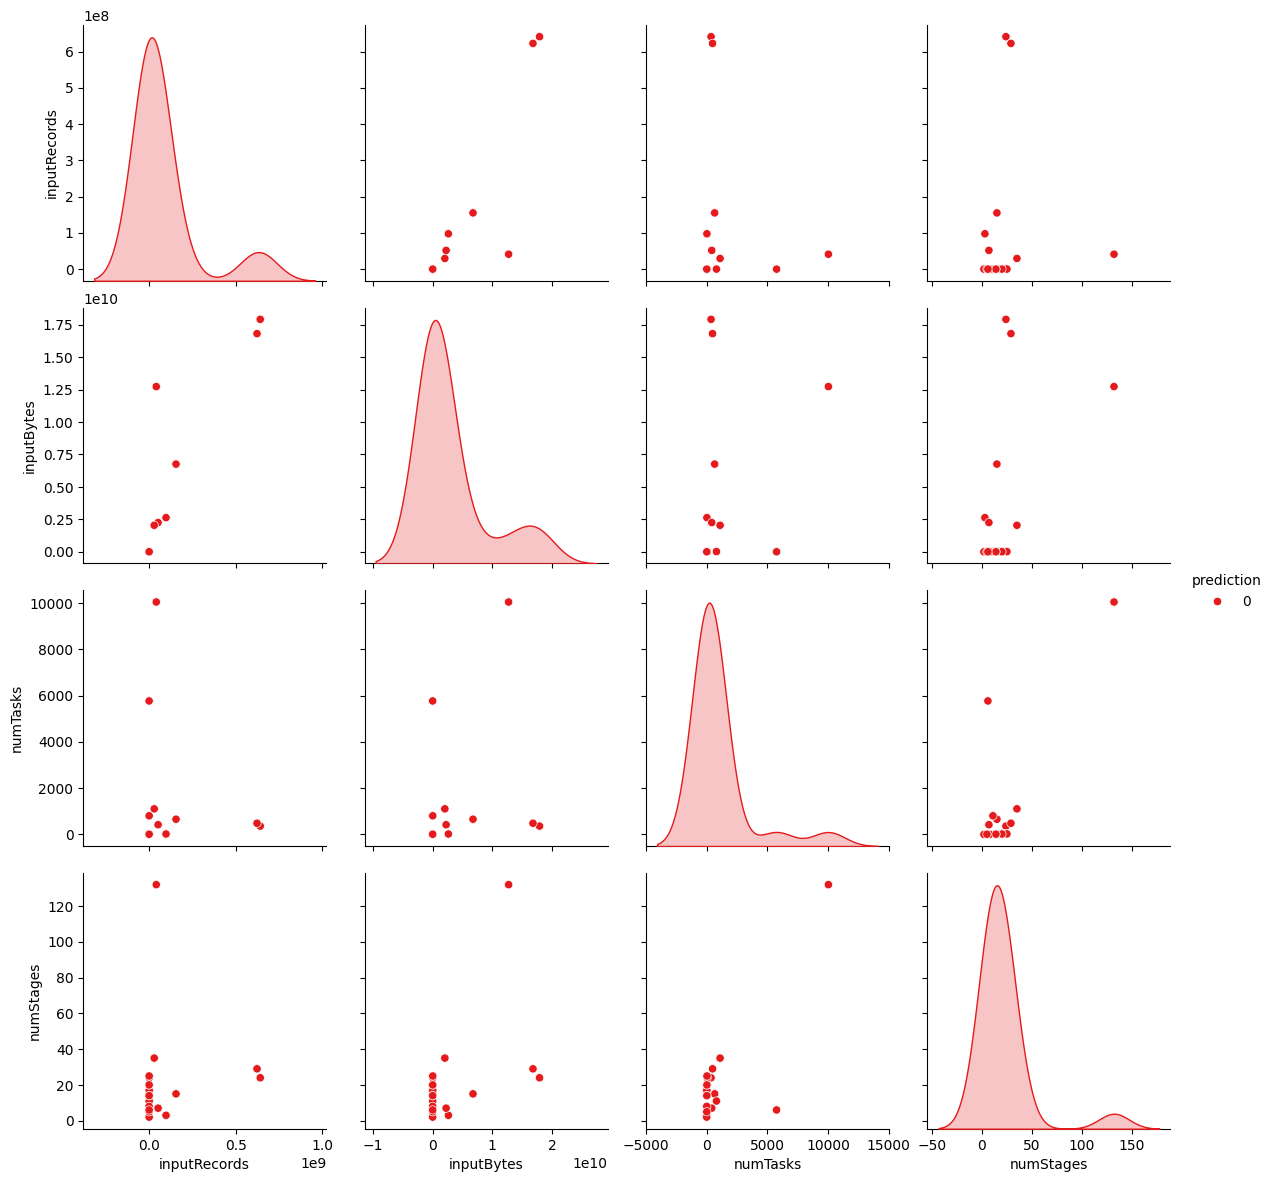

prediction
0    20
Name: count, dtype: int64

In [24]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Train an OPTICS model
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=10)
labels = optics.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_optics.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

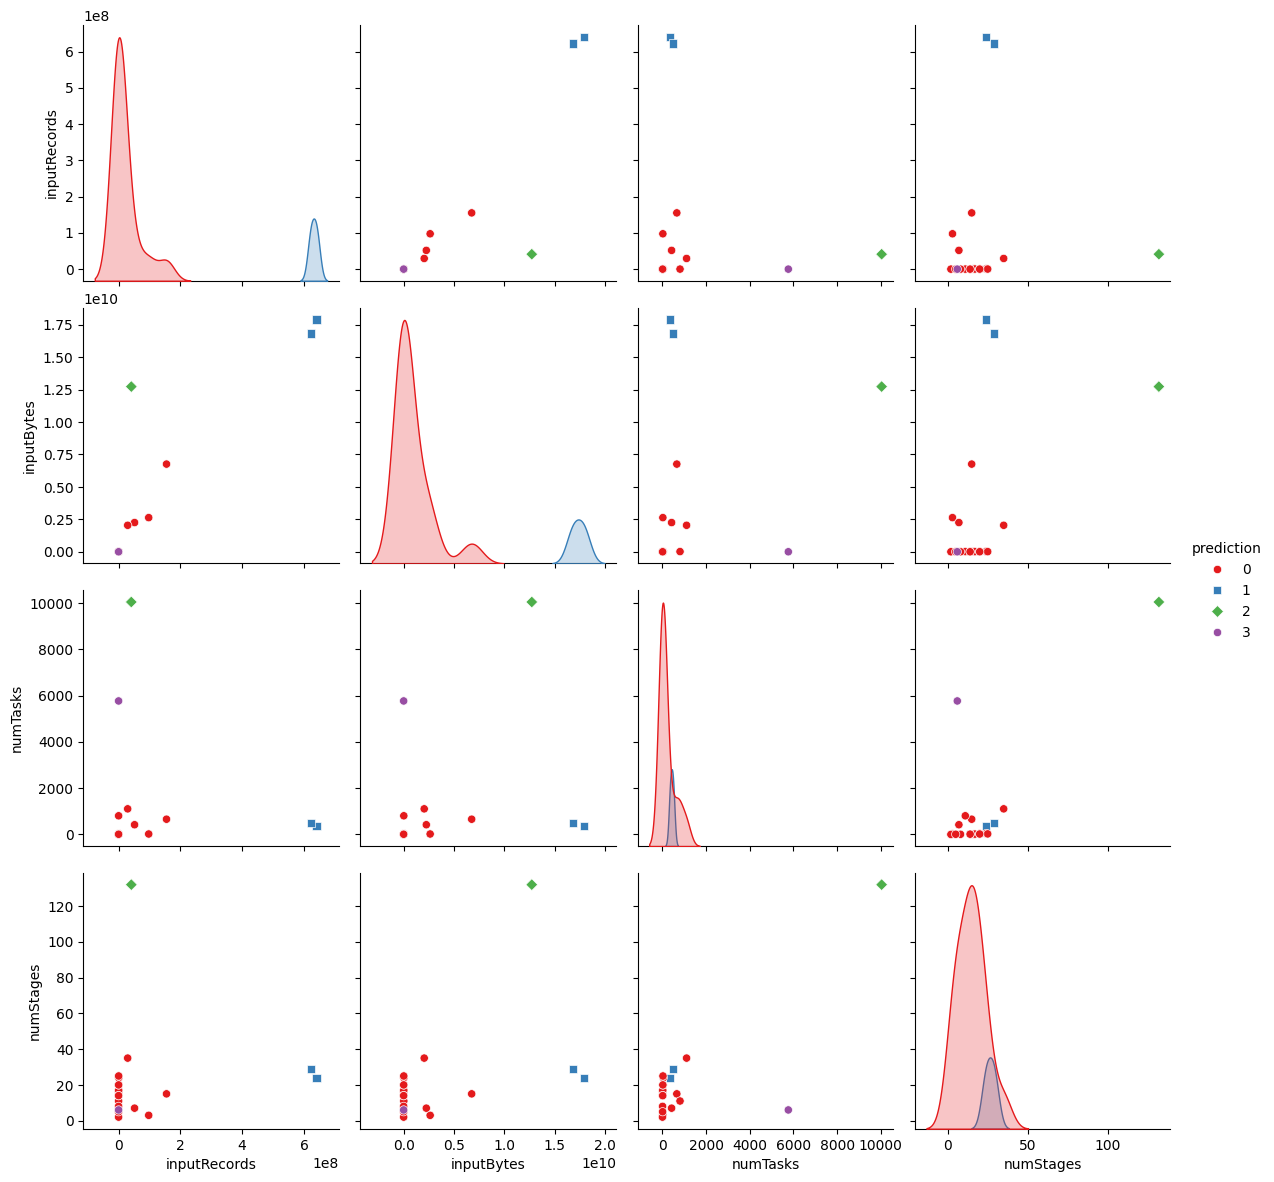

prediction
0    16
1     2
2     1
3     1
Name: count, dtype: int64

In [25]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Specify the number of clusters (k)
k = NUM_CLUSTERS

# Train an Agglomerative Clustering model
agglomerative = AgglomerativeClustering(n_clusters=k)
labels = agglomerative.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_agglomerative.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

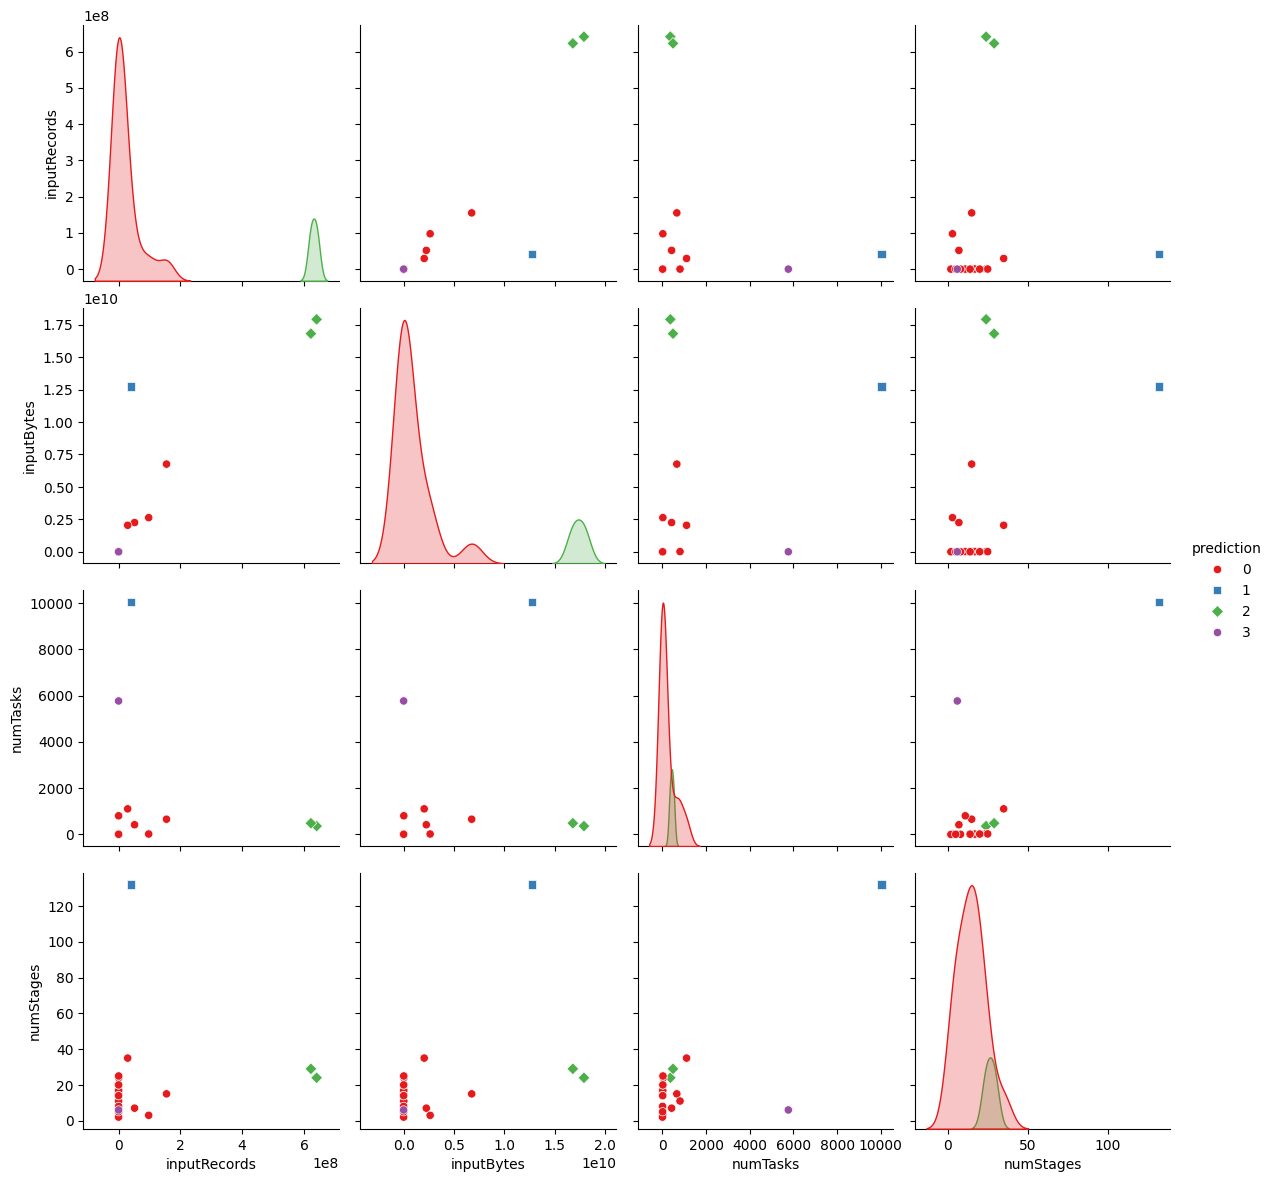

prediction
0    16
2     2
1     1
3     1
Name: count, dtype: int64

In [26]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Specify the number of clusters (k)
k = NUM_CLUSTERS

# Train a KMeans model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=200, max_iter=1000, init="k-means++")
labels = kmeans.fit_predict(df_scaled)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_kmeans.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

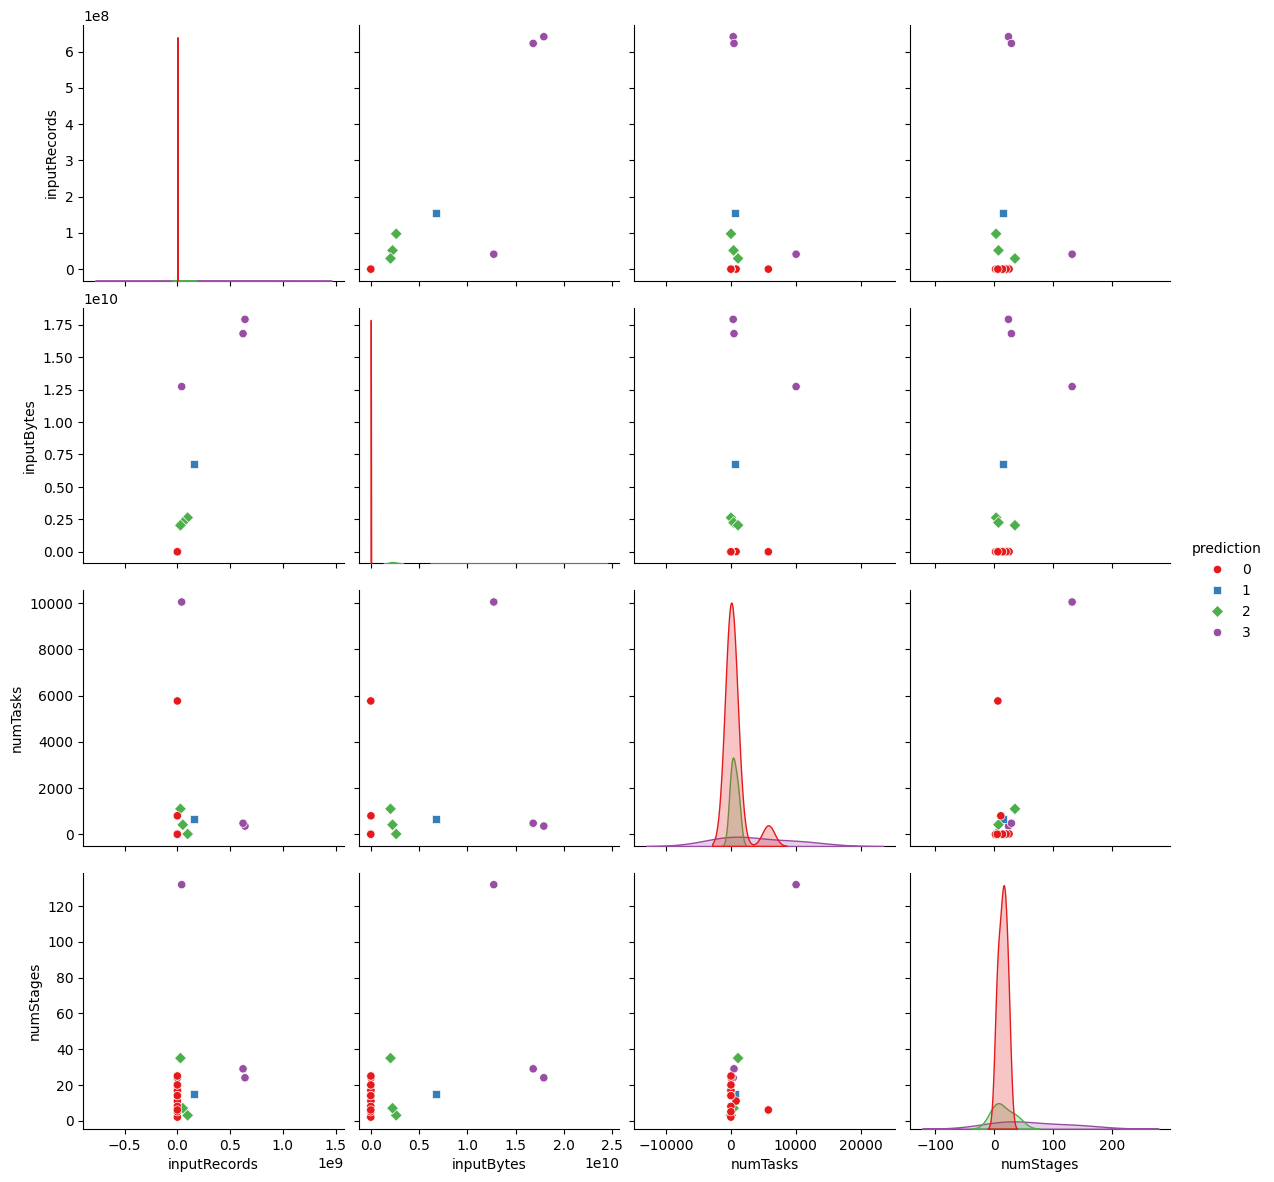

prediction
0    13
3     3
2     3
1     1
Name: count, dtype: int64

In [27]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features if needed (Fuzzy C-Means is less sensitive to feature scaling)
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)

# Convert the DataFrame to a numpy array
data_array = df.values.T  # Transpose for the expected shape

# Specify the number of clusters (c) and the fuzziness coefficient (m)
c = 4
m = 2

# Apply Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_array, c, m, error=0.005, maxiter=1000, init=None)

# Get the cluster labels
labels = np.argmax(u, axis=0)

# Add the cluster labels to the DataFrame
df["prediction"] = labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"], height=3)
plt.show()

OUTPUT_FILE = "/tmp/clustering_fuzz.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()

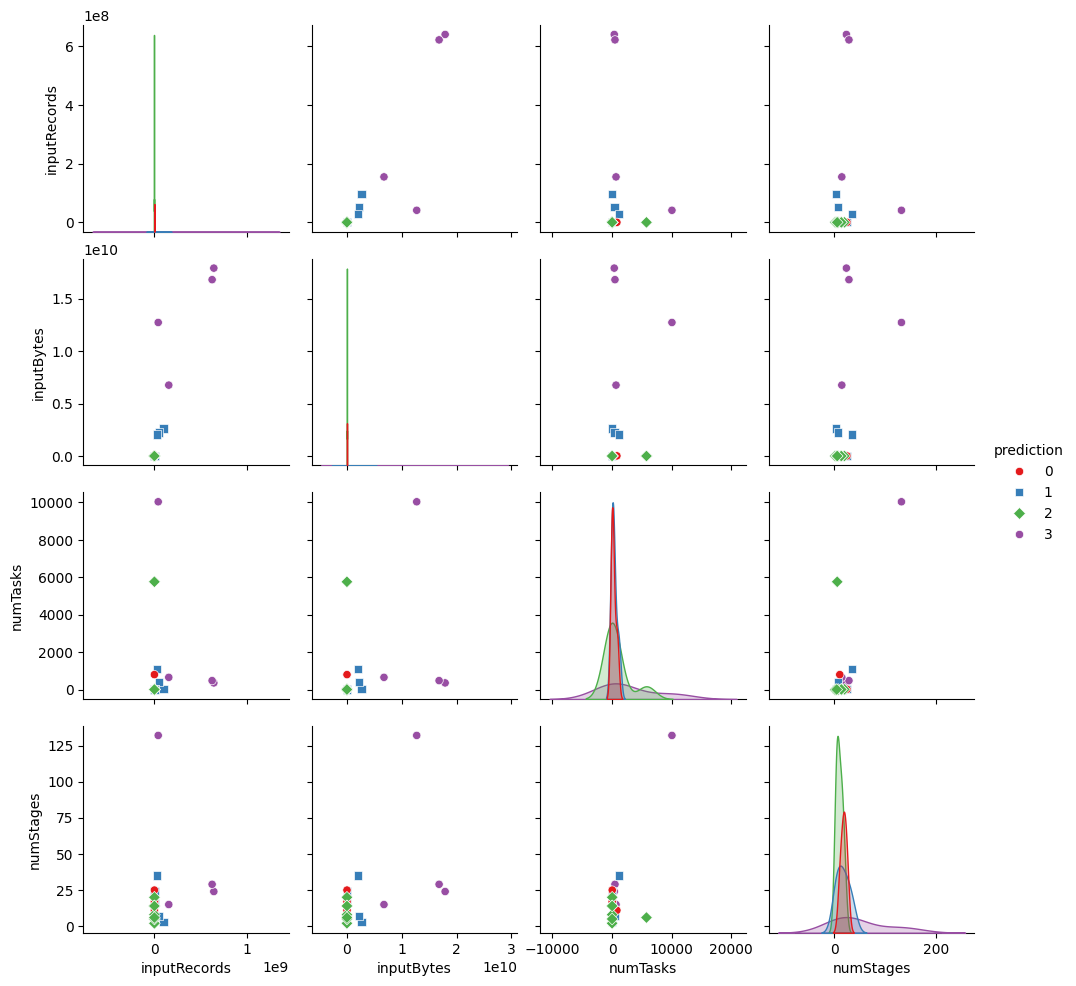

prediction
2    7
1    5
3    4
0    4
Name: count, dtype: int64

In [28]:
# Your data (replace this with your actual data loading logic)
data = df_aux

# Create a DataFrame
df = pd.DataFrame(data, columns=relevant_cols)

# Standardize the features if needed
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)

# Specify the number of clusters (k)
k = NUM_CLUSTERS

# Train a Spectral Clustering model
spectral = SpectralClustering(n_clusters=k, random_state=42, affinity="nearest_neighbors", n_neighbors=5)
predicted_labels = spectral.fit_predict(df)

# Add the cluster labels to the DataFrame
df["prediction"] = predicted_labels

# Visualize the clustering results with pair plots
sns.pairplot(df, hue="prediction", palette="Set1", markers=["o", "s", "D"])
plt.show()

OUTPUT_FILE = "/tmp/clustering_spectral.csv"
df.to_csv(OUTPUT_FILE, index=False)

df["prediction"].value_counts()